# 現状分析: 高校教員数変化
[コンテストページリンク](https://www.chuo-u.ac.jp/aboutus/efforts/ai_and_ds/event/2025/04/79632/)

## 参照データ
- 文部科学省, 文部科学統計要覧(7.高等学校)<br>`https://www.mext.go.jp/b_menu/toukei/002/002b/1417059_00009.htm`

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
import japanize_matplotlib

In [11]:
#^ データ(文部科学省の統計データより取得)
years    = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
teachers = [234970,234611,233925,232802,231319,229245,226721,224734,223246]

ser = pd.Series(teachers, index=pd.Index(years, name="year"), name="teachers").sort_index()

target_year = 2050
last_year = int(ser.index.max())
steps = target_year - last_year

#^ 定常性の判定を行う関数
def need_diff(x, alpha=0.05):
    adf_stat, pvalue, *_ = adfuller(x, autolag="AIC")
    print(pvalue > alpha)
    return pvalue > alpha

use_diff = need_diff(ser.values)

ser_work = ser.diff().dropna() if use_diff else ser.copy()


True


## 定常性の判定からわかること
以下の関数より定常性があるか確認できる
```python
def need_diff(x, alpha=0.05):
    adf_stat, pvalue, *_ = adfuller(x, autolag="AIC")
    print(pvalue > alpha)
    return pvalue > alpha
```

## ADF検定における仮説
> 帰無仮説$H_0$: 系列に単位根があり、非定常<br>対立仮説$H_1$: 非定常であると言い切れない

## 本結果からわかること
非定常であるとわかるため、差分を取る必要がある<br>
※ 教員数は、時間によって変化していると考察できる。(因果関係の有無に関しては説明できない)

In [16]:
# 自己回帰における説明変数として採用する年数
n = len(ser_work)
maxlag_safe = max(1, min(2, n // 3))
try:
    sel = ar_select_order(ser_work, maxlag=maxlag_safe, ic="aic", old_names=False)
    lags = sel.ar_lags if sel.ar_lags is not None and len(sel.ar_lags) > 0 else [1]
except Exception:
    lags = [1]  # フォールバック

# 最終セーフガード：ラグがデータ点を食い過ぎる場合は p=1 に落とす
if isinstance(lags, (list, np.ndarray)):
    p = int(np.max(lags))
else:
    p = int(lags)
if n - p - 1 <= 1:
    p, lags = 1, [1]


model = AutoReg(ser_work, lags=lags, old_names=False).fit()

/Users/yutotakagi/Develop/ds-ideathon/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/yutotakagi/Develop/ds-ideathon/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/yutotakagi/Develop/ds-ideathon/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [17]:
# 差分予測
pred_diff = model.predict(start=len(ser_work), end=len(ser_work) + steps - 1, dynamic=False)

# 近似95%区間（残差分散ベースの簡易帯）
resid_std = model.resid.std(ddof=int(model.df_model))
pred_diff_lower = pred_diff - 1.96 * resid_std
pred_diff_upper = pred_diff + 1.96 * resid_std

if use_diff:
    last_level = ser.iloc[-1]
    pred_level = last_level + pred_diff.cumsum()
    pred_level_lower = last_level + pred_diff_lower.cumsum()
    pred_level_upper = last_level + pred_diff_upper.cumsum()
else:
    pred_level = pred_diff
    pred_level_lower = pred_diff_lower
    pred_level_upper = pred_diff_upper

future_years = list(range(last_year + 1, target_year + 1))
pred_series = pd.Series(pred_level.values, index=pd.Index(future_years, name="year"), name="forecast")
pred_lower  = pd.Series(pred_level_lower.values, index=pd.Index(future_years, name="year"), name="lower")
pred_upper  = pd.Series(pred_level_upper.values, index=pd.Index(future_years, name="year"), name="upper")

print("差分学習?:", use_diff)
print("選択ラグ:", lags)
print(f"{target_year}年 予測教員数(人): {pred_series.loc[target_year]:,.0f}")
print("\n将来予測（先頭5年）:")
print(pred_series.head())


差分学習?: True
選択ラグ: [1, 2]
2050年 予測教員数(人): 181,698

将来予測（先頭5年）:
year
2024    222039.562437
2025    220845.669211
2026    219487.768715
2027    217930.152206
2028    216243.105566
Name: forecast, dtype: float64


/Users/yutotakagi/Develop/ds-ideathon/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yutotakagi/Develop/ds-ideathon/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


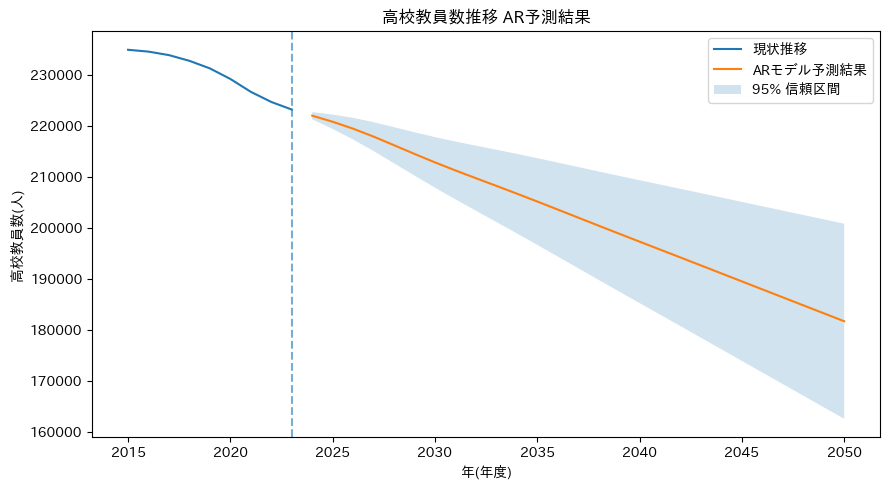

In [26]:
#^ 推移の可視化
plt.figure(figsize=(9,5))
plt.plot(ser.index, ser.values, label="現状推移")
plt.plot(pred_series.index, pred_series.values, label="ARモデル予測結果")
plt.fill_between(pred_series.index, pred_lower.values, pred_upper.values, alpha=0.2, label="95% 信頼区間")
plt.axvline(last_year, linestyle="--", alpha=0.6)
plt.title("高校教員数推移 AR予測結果")
plt.xlabel("年(年度)")
plt.ylabel("高校教員数(人)")
plt.legend()
plt.tight_layout()
plt.savefig("public/output/高校教員数推移予測結果.jpg")
plt.show()